In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
X, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
X = X

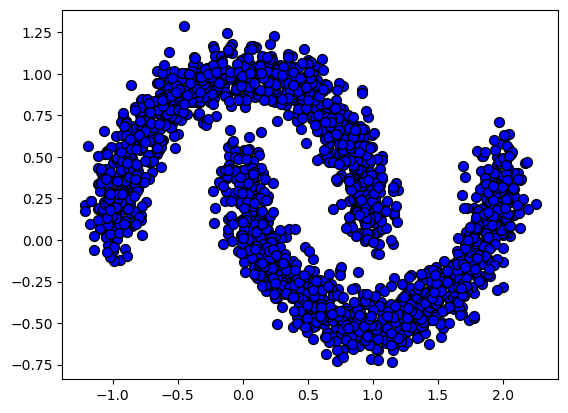

In [22]:
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50)
#plt.savefig("moonsdataset2d.svg")
plt.show()

In [23]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [24]:
class Denoiser(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Denoiser, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        t = torch.unsqueeze(t, 1)
        x_for = torch.cat((x, t), dim=1)
        x_for = torch.relu(self.fc1(x_for))
        x_for = torch.relu(self.fc2(x_for))
        x_for = torch.relu(self.fc3(x_for))
        x_for = torch.relu(self.fc4(x_for))
        return self.fc5(x_for)

model = Denoiser(2, 2, 64).to(device)

In [25]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02, n_skip = 0):
        self.model = model
        self.timesteps = timesteps-n_skip
        self.reversed_time_steps = np.arange(self.timesteps)[::-1]
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.alphas = self.alphas[n_skip:]
        self.betas = self.betas[n_skip:]
        self.alphas_cumprod = self.alphas_cumprod[n_skip:]
        print(self.alphas_cumprod)

    def sample_sde(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                eps = self.model(x, t_tensor)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
        return x

    def sample_ode(self, num_samples):
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                x = self.ode_step(x,t_tensor)
        return x
        
    def ode_step(self, x, t_tensor):
        with torch.no_grad():
            eps = self.model(x, t_tensor)
            score = -eps/torch.sqrt(1.0 - self.alphas_cumprod[t_tensor])[:,None]
            beta_t = self.betas[t_tensor]
            xip = (2-torch.sqrt(1-beta_t))[:,None]*x+1/2*beta_t[:,None]*score
            x = xip# + torch.sqrt(beta_t)*noise
        return x
        
    def ode_score(self, x, t, ns): # Not used
        with torch.no_grad():
            eps = self.model(x, t)
            alpha_terms = torch.sqrt(1.0 - self.alphas_cumprod[ns].to(x.device))
            score = -eps / alpha_terms.view(-1, 1) 
        return score

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def add_noise(self,batch,t_tensor):
        noise = torch.randn_like(batch, dtype=torch.float32)
        noisy_data = torch.sqrt(self.alphas_cumprod[t_tensor]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t_tensor]).view(-1, 1) * noise
        return noisy_data

    def train(self, data, epochs=1000, batch_size=64, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
        losses = []
        mean_loss = 0
        i = 0

        for epoch in range(epochs):
            
            for batch in dataloader:
                optimizer.zero_grad()
                t = torch.randint(0, self.timesteps, (batch.size(0),), device=batch.device).long()
                noise = torch.randn_like(batch, dtype=torch.float32)
                noisy_data = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1) * noise
                predicted_noise = self.model(noisy_data, t)
                loss = criterion(predicted_noise, noise)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                optimizer.step()

            if epoch % 100 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
        return losses
    
ddpm = DDPM(model, timesteps=80, beta_start = 0.001, beta_end = 0.2)

tensor([9.9900e-01, 9.9548e-01, 9.8947e-01, 9.8101e-01, 9.7014e-01, 9.5695e-01,
        9.4153e-01, 9.2399e-01, 9.0444e-01, 8.8304e-01, 8.5991e-01, 8.3522e-01,
        8.0914e-01, 7.8183e-01, 7.5348e-01, 7.2426e-01, 6.9434e-01, 6.6391e-01,
        6.3315e-01, 6.0221e-01, 5.7127e-01, 5.4048e-01, 5.0999e-01, 4.7993e-01,
        4.5043e-01, 4.2162e-01, 3.9358e-01, 3.6642e-01, 3.4021e-01, 3.1502e-01,
        2.9090e-01, 2.6789e-01, 2.4603e-01, 2.2533e-01, 2.0581e-01, 1.8746e-01,
        1.7027e-01, 1.5423e-01, 1.3931e-01, 1.2549e-01, 1.1272e-01, 1.0096e-01,
        9.0181e-02, 8.0323e-02, 7.1340e-02, 6.3182e-02, 5.5797e-02, 4.9136e-02,
        4.3145e-02, 3.7777e-02, 3.2981e-02, 2.8711e-02, 2.4922e-02, 2.1569e-02,
        1.8614e-02, 1.6016e-02, 1.3741e-02, 1.1754e-02, 1.0025e-02, 8.5253e-03,
        7.2283e-03, 6.1104e-03, 5.1499e-03, 4.3275e-03, 3.6255e-03, 3.0283e-03,
        2.5218e-03, 2.0937e-03, 1.7329e-03, 1.4300e-03, 1.1764e-03, 9.6485e-04,
        7.8889e-04, 6.4304e-04, 5.2253e-

In [26]:
ddpm.load("models/ode_simplemoons")

In [27]:
new_samples = ddpm.sample_ode(num_samples=2000).cpu().detach().numpy()

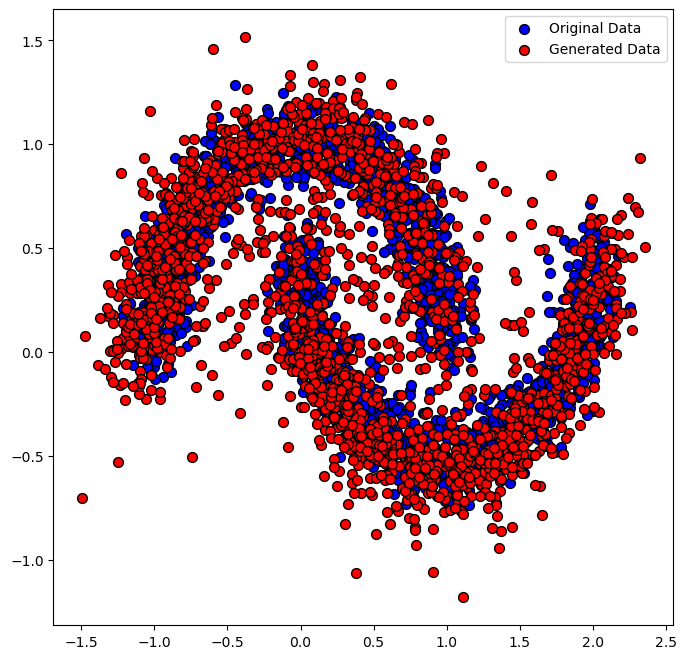

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()

In [29]:
class MLPStudent(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        t = t.view(-1, 1)
        xt = torch.cat([x, t], dim=1)
        h = F.silu(self.fc1(xt))
        h = F.silu(self.fc2(h))
        h = F.silu(self.fc3(h))
        h = F.silu(self.fc4(h))
        return (t==0).float()*x+(1-(t==0).float())*(self.fc5(h))

In [30]:
class ConsistencyModel:
    def __init__(self, student_model, teacher_model, timesteps=80, learning_rate=1e-3, mu=0.95):
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.timesteps =  teacher_model.timesteps
        self.learning_rate = learning_rate
        self.mu = mu
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.theta_minus_model = self.create_ema_model()
        
    def karras_schedule(self, i, T=80.0, epsilon=2e-3, rho=7): # Not used at the end but we tried implementation of karras schedule
        N = self.timesteps
        t_i = (epsilon**(1/rho) + (i - 1) / (N - 1) * (T**(1/rho) - epsilon**(1/rho)))**rho
        return t_i
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = type(self.student_model)()
        ema_model.load_state_dict(self.student_model.state_dict())
        for param in ema_model.parameters():
            param.requires_grad = False
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data
    
    def load(self, path):
        """Load the model's state from a file."""
        self.student_model.load_state_dict(torch.load(path, map_location=next(student_model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.student_model.state_dict(), path)

    def train(self, dataset, epochs=1000, batch_size=64):
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            epoch_loss = 0
            for x in dataloader:
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                t_n = n   # Select t_n
                
                t_np1 = t_n+1  # Select t_n+1
                
                # Sample x_{t_{n+1}}
                #noise = torch.randn_like(x, device=x.device)
                
                x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                
                # Compute teacher output (ODE solver)
                with torch.no_grad():
                    x_hat_tn = self.teacher_model.ode_step(x_tnp1, t_np1)
                    #x_hat_phi_tn = x_tnp1 - t_np1.view(-1, 1) * (t_n.view(-1, 1) - t_np1.view(-1, 1)) * phi_tn
                
                # Compute student output
                student_output = self.student_model(x_tnp1, t_np1)
                
                with torch.no_grad():  # Stop gradient flow
                    theta_minus_output = self.theta_minus_model(x_hat_tn, t_n)
                
                loss = self.loss_fn(student_output, theta_minus_output)
                loss.backward()
                self.optimizer.step()
                
                self.update_ema()
                
                epoch_loss += loss.item()
            
            if epoch%100==0:
                print(f"Epoch {epoch}, Loss: {epoch_loss / len(dataloader)}")
        
        return self.student_model

In [31]:
student_model = MLPStudent().to(device)
consistency_model = ConsistencyModel(student_model, ddpm)

In [32]:
#student_model = consistency_model.train(data, epochs=10000, batch_size=64)

In [33]:
#torch.save(student_model.state_dict(), "models/distillation_consistency")

In [34]:
student_model.load_state_dict(torch.load("models/student_model", map_location=next(student_model.parameters()).device))

<All keys matched successfully>

In [35]:
def sample_consistency_model(model, num_samples=10000):
    start_time = time.time()
    x = torch.randn((num_samples, 2), device=device)
    t = torch.ones(num_samples, device=device)*(consistency_model.timesteps-1)
    with torch.no_grad():
        x = model(x, t)
    end_time = time.time()
    print("total time:",end_time-start_time)
    return x

samples = sample_consistency_model(student_model, num_samples=2000).cpu().detach().numpy()

total time: 0.0021343231201171875


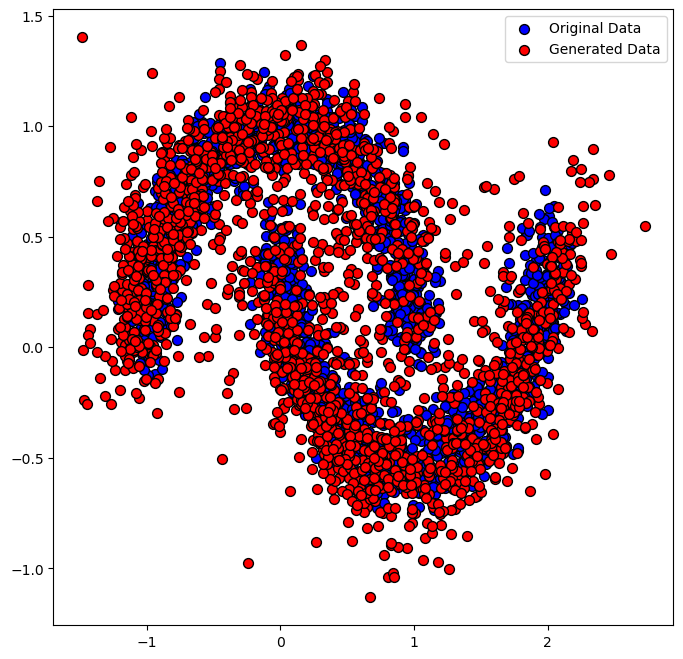

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
#plt.savefig('distillation.svg')
plt.show()